In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                import cv2
import os
import csv
import numpy as np
import itertools
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
class_names = {1: 'EOSINOPHIL', 2: 'LYMPHOCYTE', 3: 'MONOCYTE', 4:'NEUTROPHIL'}

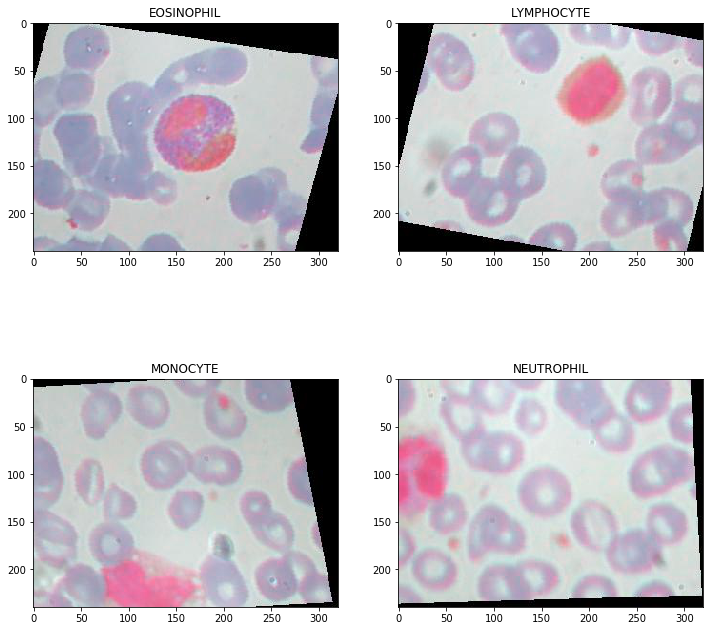

In [3]:
images = [
    'dataset2-master/images/TRAIN/EOSINOPHIL/_0_1169.jpeg',
    'dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg',
    'dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg',
    'dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
]
fig = plt.figure(figsize=(12, 12))

for i in range(1, 5):
    img = cv2.imread(images[i-1])
    fig.add_subplot(2, 2, i)
    plt.title(class_names[i])
    plt.imshow(img)
plt.show()

In [4]:
training_data_folder = 'dataset2-master/images/TRAIN/'
testing_data_folder = 'dataset2-master/images/TEST/'

In [5]:
wbc_labels = {'EOSINOPHIL': 1, 'LYMPHOCYTE': 2, 'MONOCYTE': 3, 'NEUTROPHIL':4}

In [6]:
import scipy.misc
from tqdm import tqdm
def get_data(folder):
    data = []
    labels = []
    for wbc_type in os.listdir(folder):
        for file in tqdm(os.listdir(folder + wbc_type)):
            img_file = cv2.imread(folder + wbc_type + '/' + file)
            if img_file is not None:
                img_file = Image.fromarray(img_file)
                img_file = img_file.resize((100,75),3)
                img_arr = np.asarray(img_file)
                data.append(img_arr)
                labels.append(wbc_labels[wbc_type])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [7]:
training_data, training_labels = get_data(training_data_folder)
testing_data, testing_labels = get_data(testing_data_folder)

100%|██████████| 620/620 [00:01<00:00, 532.75it/s]


{'EOSINOPHIL': 1, 'LYMPHOCYTE': 2, 'MONOCYTE': 3, 'NEUTROPHIL': 4}


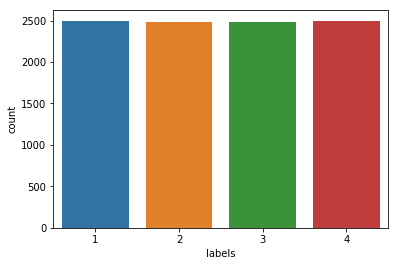

In [8]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=training_labels
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(wbc_labels)

In [9]:
training_data=np.array(training_data)
training_data=training_data/255.0

testing_data=np.array(testing_data)
testing_data=testing_data/255.0

In [10]:
from keras.utils.np_utils import to_categorical
training_label_hot = to_categorical(training_labels, num_classes=5)
testing_label_hot = to_categorical(testing_labels, num_classes=5)
print(wbc_labels)

Using TensorFlow backend.


{'EOSINOPHIL': 1, 'LYMPHOCYTE': 2, 'MONOCYTE': 3, 'NEUTROPHIL': 4}


In [11]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [12]:
import keras
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

In [14]:

base_model = InceptionV3(weights='imagenet', include_top=False, 
                         input_shape=(75, 100, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

model.compile(optimizer=keras.optimizers.Adadelta(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

history = model.fit_generator(datagen.flow(training_data,training_label_hot, batch_size=32),
        steps_per_epoch=len(training_data) / 32, epochs=32, validation_data = [testing_data, testing_label_hot],
        callbacks = [MetricsCheckpoint('logs')], workers=5)


Epoch 1/32
312/311 [==============================] - 543s 2s/step - loss: 1.2399 - acc: 0.4178 - val_loss: 1.3078 - val_acc: 0.5078
Epoch 2/32
312/311 [==============================] - 538s 2s/step - loss: 0.5009 - acc: 0.7991 - val_loss: 0.8628 - val_acc: 0.7161
Epoch 3/32
312/311 [==============================] - 515s 2s/step - loss: 0.2997 - acc: 0.8873 - val_loss: 4.2238 - val_acc: 0.3675
Epoch 4/32
312/311 [==============================] - 515s 2s/step - loss: 0.2049 - acc: 0.9247 - val_loss: 2.0481 - val_acc: 0.4938
Epoch 5/32
312/311 [==============================] - 514s 2s/step - loss: 0.1687 - acc: 0.9405 - val_loss: 2.8562 - val_acc: 0.4845
Epoch 6/32
312/311 [==============================] - 514s 2s/step - loss: 0.1062 - acc: 0.9646 - val_loss: 0.9968 - val_acc: 0.7732
Epoch 7/32
312/311 [==============================] - 514s 2s/step - loss: 0.0811 - acc: 0.9751 - val_loss: 0.8194 - val_acc: 0.8335
Epoch 8/32
312/311 [==============================] - 514s 2s/step - 

In [15]:
model.save_weights('inception.h5')
model_yaml = model.to_yaml()
with open("model2.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [16]:
score = model.evaluate(testing_data, testing_label_hot, verbose=0)
print('\nInception v3 #1C - accuracy:', score[1],'\n')


Inception v3 #1C - accuracy: 0.8367511057738659 



In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn

/home/ronald/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [18]:

def plotInceptionLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [20]:
# print(list(map_characters.values()))

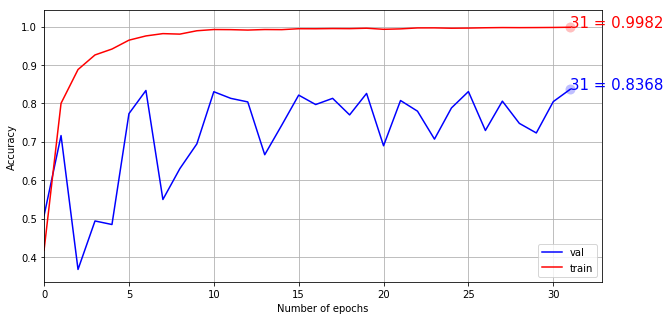

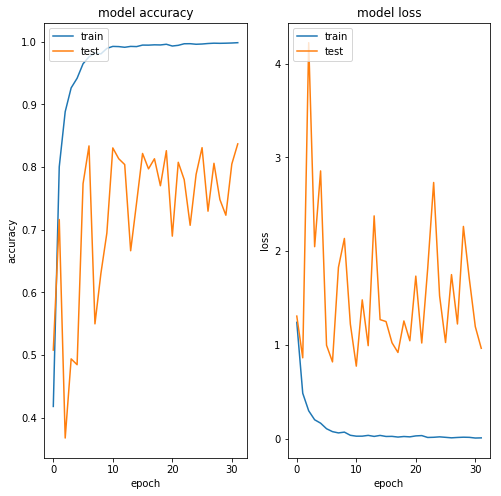

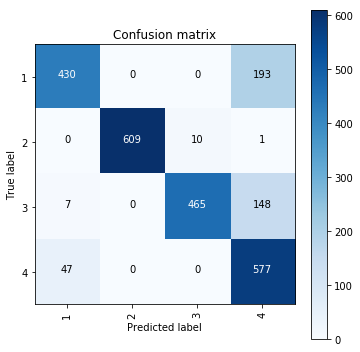

In [21]:
y_pred = model.predict(testing_data)
map_characters = wbc_labels
# print('\n', sklearn.metrics.classification_report(np.where(testing_label_hot > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(testing_label_hot,axis=1)
plotInceptionLearningCurve()
plt.show()  
plot_learning_curve(history)
plt.show()
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(wbc_labels.values())) 
plt.show()

In [22]:
print('\n', sklearn.metrics.classification_report(
    np.where(testing_label_hot > 0)[1],
    np.argmax(y_pred, axis=1),
    target_names=list(map_characters.keys())), sep='')


              precision    recall  f1-score   support

  EOSINOPHIL       0.89      0.69      0.78       623
  LYMPHOCYTE       1.00      0.98      0.99       620
    MONOCYTE       0.98      0.75      0.85       620
  NEUTROPHIL       0.63      0.92      0.75       624

   micro avg       0.84      0.84      0.84      2487
   macro avg       0.87      0.84      0.84      2487
weighted avg       0.87      0.84      0.84      2487

